<h1><center>Does the EIA Weekly Petroleum Stock Report <br><i>really</i> impact Crude Oil price?</center></h1>

<h1>Loading Data</h1>

In [1]:
import math
import pandas as pd
import numpy as np
import datetime as dt

import pytz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

wall_st = pytz.timezone("America/New_York")

<h2 align="left"> <font color='32a8a6'>WPSR Inventory Data</font></h2>

In [112]:
inventory_data = pd.read_csv('./reports.csv', index_col=0)

In [113]:
def format_inventory_data(df: pd.DataFrame) -> pd.DataFrame:
    # Extract report date from endpoint url
    df['Report Date'] = df['Endpoint'].str.extract(r'(\d{4}_\d{2}_\d{2})')
    # Drop URL, Report Date
    df = df.drop('Endpoint', axis=1)
    df = df.reset_index(drop=True)
    # Set report date as index, convert to DatetimeIndex
    df = df.set_index('Report Date')
    df.index = pd.to_datetime(df.index, format='%Y_%m_%d').tz_localize(wall_st)
    return df

In [114]:
inv = format_inventory_data(inventory_data)

In [117]:
inv.head()

,Crude Oil,Total Motor Gasoline,Fuel Ethanol,Kerosene-Type Jet Fuel,Distillate Fuel Oil,Residual Fuel Oil,Propane/Propylene,Other Oils,Unfinished Oils,Total Stocks (Including SPR),Total Stocks (Excluding SPR),SPR
Report Date,,,,,,,,,,,,
2011-08-03 00:00:00-04:00,1074.736,215.179,18.901,44.992,152.254,36.197,49.354,215.807,84.428,1807.420,1087.659,719.761
2011-08-10 00:00:00-04:00,1067.017,213.591,18.153,44.382,151.517,36.715,49.595,215.714,85.285,1796.684,1079.417,717.267
2011-08-17 00:00:00-04:00,1065.336,210.081,17.582,44.269,153.966,37.397,50.382,216.303,85.725,1795.316,1083.963,711.353
2011-08-24 00:00:00-04:00,1058.321,211.436,18.243,43.346,155.697,38.068,52.045,217.333,85.369,1794.489,1087.938,706.551
2011-08-31 00:00:00-04:00,1058.876,208.641,17.893,43.820,156.060,38.435,53.590,216.794,83.703,1794.109,1092.284,701.825


In [126]:
inv_changes = inv.pct_change().dropna(axis=0)

<h2 align="left"> <font color='32a8a6'>WTI Spot Price Data</font></h2>

We can get daily price data for the WTI spot price from the Yahoo Finance API.

In [50]:
import yfinance as yf

In [51]:
first_inventory_date = inv.index.min()
last_inventory_date = inv.index.max()

In [52]:
today = dt.datetime.now(tz=wall_st)
days_per_year = 365.2425
years_ago = int(( today - first_inventory_date).days // days_per_year) + 1

In [53]:
# get relevant historical market data from Yahoo Finance
wti = yf.Ticker("CL=F")
hist = wti.history(period=f"{years_ago}y")

In [54]:
hist.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2011-05-06 00:00:00-04:00,99.760002,102.379997,94.629997,97.180000,606528,0.0,0.0
2011-05-09 00:00:00-04:00,98.110001,103.400002,97.419998,102.550003,469290,0.0,0.0
2011-05-10 00:00:00-04:00,102.440002,103.949997,100.120003,103.879997,439607,0.0,0.0


We use percentage change here to account for varying prices over time.

In [55]:
price_changes = 100 * (hist.Close - hist.Open) / hist.Open

<h1>Statistical Analysis</h1>

<h2><font color='32a8a6'>Descriptive Analysis</font></h2>

<h3> <font color='gray'>Contingency Table</font></h3>

In [134]:
shared_index = inv_changes.index.intersection(price_changes.index)

In [137]:
market_dir = np.where(price_changes.loc[shared_index] >= 0,'up', 'down')
stock_dir = np.where(inv_changes.loc[shared_index, 'Crude Oil'] >= 0, 'build', 'draw')

In [138]:
contingency_table = pd.crosstab(market_dir, stock_dir, rownames=['Spot Price'], colnames=['Crude Stocks'])
contingency_table

Crude Stocks,build,draw
Spot Price,,
down,166,151
up,154,194


<h3 align="left"> <font color='gray'>Testing for Independence - $\chi^2$</font></h3>

<div class="alert alert-block alert-info">
We have a 2-dimensional categorical data set comparing the dichotomous price change and inventory change.

We can use Chi-squared to test for the independence of market direction to inventory change:

$H_0$ - <i>spot price change has no dependence on total crude inventory change</i>
</div>

In [60]:
from scipy.stats import chi2_contingency

In [61]:
res = chi2_contingency(contingency_table)

In [158]:
print(f"Chi-squared:\n\t{'Statistics':>10}:{res.statistic:>8.4f}\n\t{'P-value':>10}:{res.pvalue:>8.4f}")

Chi-squared:
	Statistics:  4.0549
	   P-value:  0.0440


With a 95% confidence interval, we would reject the null hypothesis as our p-value < 0.05

<h4>Effect Size</h4>Phi ($\phi$) coefficient

In [159]:
phi = math.sqrt(res.statistic / len(market_change))
round(phi, 4)

0.0781

<h2><font color='32a8a6'>Univariate Linear Correlation</font></h2>

<Axes: xlabel='Crude Oil', ylabel='Count'>

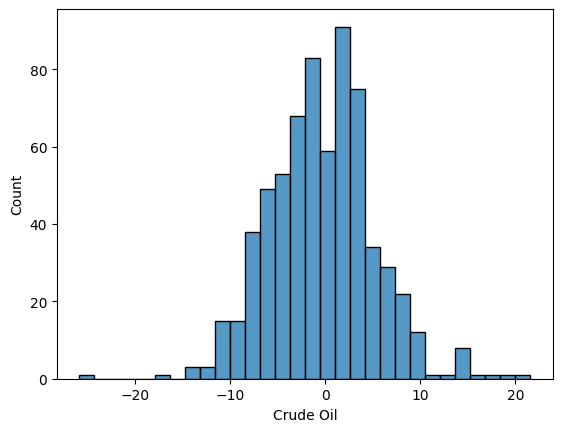

In [66]:
sns.histplot(crude_change)

We can test for the correlation between the Inventory Change and the Spot price Change using Pearsons Correlation Coefficient:

<h4>Covariance</h4>

$Cov(X, Y) = E[(X - E[X])(Y - E[Y])]$

In [121]:
X = crude_change.loc[shared_index]
Y = price_changes.loc[shared_index]

In [123]:
cov = X.cov(Y)
round(cov, 4)

-0.0388

<h4>Correlation Coefficient</h4>

$\rho_{X,Y} = \frac{Cov(X, Y)}{\sigma_X \sigma_Y}$

In [69]:
rho = cov / (X.std() * Y.std())

In [124]:
round(rho, 4)

-0.0028

<h2 align="left"> <font color='32a8a6'>Multivariate Analysis</font></h2>

<div class="alert alert-block alert-info">
<b>SPR independence</b>
<br>
Unlike the other variables, change in the SPR is dictated by the US Government. They can <b>choose</b> whether to withdraw or replace SPR inventory depending on the current Supply / Demand levels. Therefore, this variable is not independent and randomly-distributed.
<br><br>
<b>Collinearity</b>
<br>
We must remove the summary columns Total Stocks and SPR as these will have <i>collinearity</i> with other inventory columns.
</div>

In [76]:
inv_changes = inv_changes.drop(['SPR', 'Total Stocks (Including SPR)', 'Total Stocks (Excluding SPR)'], axis=1)

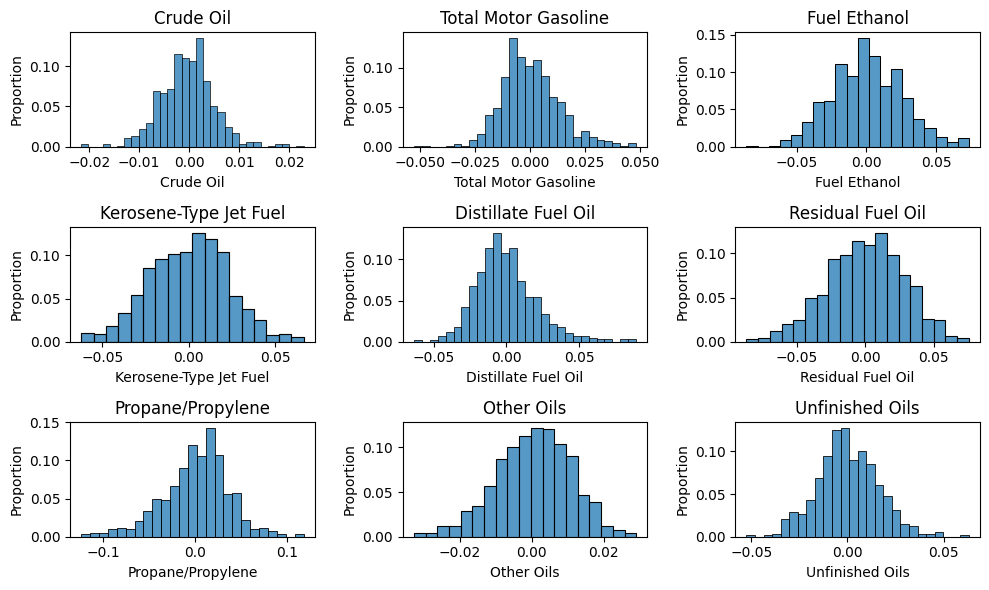

In [168]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(10, 6))
axes = axes.flatten()     

for ax, col in zip(axes, inv_changes.columns):
  sns.histplot(inv_changes[col], ax = ax, stat='proportion')
  ax.set_title(col)

fig.tight_layout()

<h3>Data Normalisation</h3>

<div class="alert alert-block alert-info">
The data contains significant outliers preciptating from major geopolitical events, for example the COVID-19 pandemic and the Invasion of Ukraine, resulting in increased <b>kurtosis</b> of many of the distributions of stock changes.
<br><br>
To standardise the data to be Normally distributed without being impacted by these outliers, we can use the Sklearn <code>RobustScaler</code>
</div>

In [78]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder

In [79]:
transformer = RobustScaler().fit(inv_changes)

In [80]:
scaled_inv_changes = pd.DataFrame(transformer.transform(inv_changes),
                                  columns=inv_changes.columns,
                                  index=inv_changes.index)

<h1>Testing market impact</h1>

In [228]:
feature_df = scaled_inv_changes.copy()

# we can use the report dates DatetimeIndex for a trick shortly
report_dates = feature_df.index

shared_index = report_dates.intersection(price_changes.index)
report_impact = price_changes.loc[shared_index].copy()
feature_df = feature_df.loc[shared_index].copy()

<h2 align="left"> <font color="32a8a6">Feature Selection</font></h2>

In [175]:
X = feature_df.values
y = np.where(report_impact.values > 0, 1, -1)

In [187]:
from sklearn.feature_selection import SelectKBest, f_classif

In [188]:
kbest = SelectKBest(f_classif, k=2).fit(X, y)

In [189]:
top_features = kbest.get_feature_names_out(input_features=feature_df.columns)
top_features

array(['Crude Oil', 'Total Motor Gasoline'], dtype=object)

In [190]:
X_new = kbest.transform(X)

In [191]:
less_feature_df = pd.DataFrame(X_new, columns=top_features, index=feature_df.index)

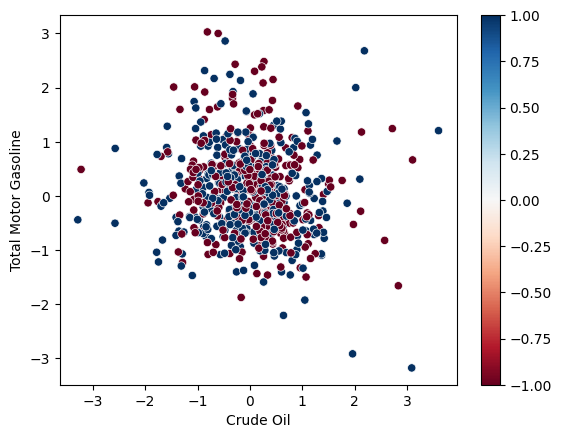

In [192]:
ax = sns.scatterplot(data=less_feature_df,
                     x=top_features[0],
                     y=top_features[1],
                     palette='RdBu',
                     hue=y)

norm = plt.Normalize(y.min(), y.max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, ax=ax)

plt.show()

<h2 align="left"> <font color='32a8a6'>Linear Regression</font></h2>

In [193]:
from sklearn.linear_model import LinearRegression

In [194]:
reg = LinearRegression().fit(X, y)

In [195]:
reg.score(X, y)

0.01781644404321614

In [196]:
pd.DataFrame(reg.coef_, index=feature_df.columns, columns=['weight']).sort_values('weight', ascending=False)

,weight
Kerosene-Type Jet Fuel,0.086662
Unfinished Oils,0.043092
Distillate Fuel Oil,0.019593
Fuel Ethanol,-0.021881
Residual Fuel Oil,-0.030480
Other Oils,-0.048071
Propane/Propylene,-0.075024
Crude Oil,-0.092066
Total Motor Gasoline,-0.118460


<h2 align="left"> <font color='32a8a6'>Decision Tree Regression</font></h2>

In [98]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [198]:
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [199]:
reg.score(X_test, y_test)

-1.0242424242424235

<h2 align="left"> <font color='32a8a6'>Dimensionality Reduction</font></h2>

In [102]:
from sklearn.decomposition import PCA

In [200]:
pca = PCA(n_components=2).fit(X)

In [201]:
pca.explained_variance_ratio_

array([0.24070633, 0.18234879])

In [202]:
feature_weights = pd.DataFrame(pca.components_, index=['PC1', 'PC2'], columns=feature_df.columns)

In [203]:
feature_weights.T

,PC1,PC2
Crude Oil,-0.248725,0.438549
Total Motor Gasoline,0.551524,0.141545
Fuel Ethanol,0.177662,0.188163
Kerosene-Type Jet Fuel,0.170751,-0.081847
Distillate Fuel Oil,0.529796,-0.210807
Residual Fuel Oil,-0.020484,0.114749
Propane/Propylene,-0.082346,-0.730041
Other Oils,-0.366703,-0.356167
Unfinished Oils,-0.388436,0.167670


In [204]:
Xtrans = pca.transform(X)

In [205]:
reduced_inv = pd.DataFrame(Xtrans, columns=['pc1', 'pc2'], index=shared_index)
reduced_inv['label'] = y

<Axes: xlabel='pc1', ylabel='pc2'>

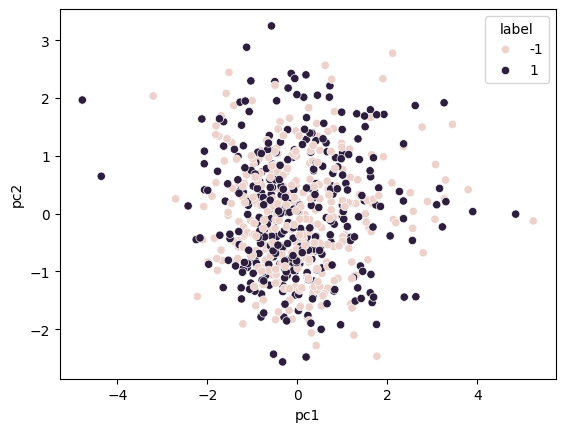

In [207]:
sns.scatterplot(reduced_inv, x='pc1', y='pc2', hue='label')

<h1>Is the inventory change <i>priced-in</i>?</h1>

<div class="alert alert-block alert-info">
    If there is no statistical impact of inventory change to market price, it would suggest that the implied change in supply / demand has been <i>priced-in</i> to the market price already.
    <br>
    By aggregating the oil price change in the week prior to the report date, we can test for correlation with this new variable.
</div>

In [209]:
report_dates = inv_changes.index
first_inventory_date = inv_changes.index.min()
last_inventory_date = inv_changes.index.max()

In [210]:
# We need the data from the day of the first report to six days prior to the report
prices = hist.loc[first_inventory_date - dt.timedelta(days=6):last_inventory_date].copy()

In [211]:
price_changes = (prices.Close - prices.Open) / prices.Open

In [212]:
last_issued_index = report_dates.searchsorted(price_changes.index, side='left') 

Since we have a list of values equal to length of the <code>price_changes</code>, we can pass these into the <code>pd.Series.groupby</code> as the mapper to determine the groups based on the list values, in this case, the last report date. Then, we can use the <code>sum</code> aggregator to return the total price change percentage for the days following a WPSR report.

In [224]:
prior_change = price_changes.groupby(report_dates[last_issued_index]).sum()

In [225]:
priced_in = pd.DataFrame(index=scaled_inv_changes.index)
priced_in['inv_change'] = scaled_inv_changes['Crude Oil'].copy()
priced_in['spot_change'] = prior_change.copy()

<Axes: xlabel='inv_change', ylabel='spot_change'>

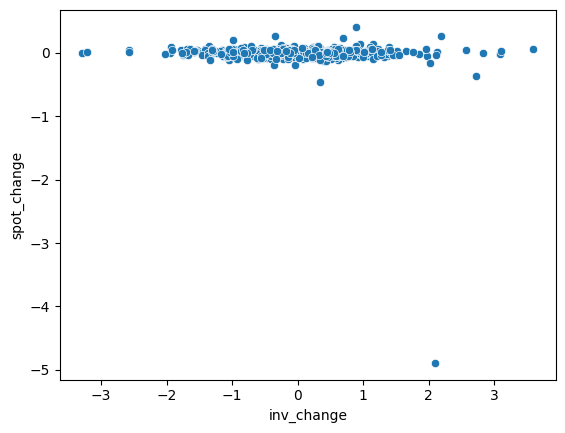

In [226]:
sns.scatterplot(priced_in, x='inv_change', y='spot_change')

<h4>Removing outlying price movements</h4>

Outlying price movements may overwhelm any impact caused by the WPSR. We can identify and remove outliers using the Z-Score.

This is a statistical measurement of the price change in relationship to the mean of all price changes.

In [217]:
from scipy.stats import zscore

In [218]:
zscores = zscore(priced_in['spot_change'])

We can discount any days when the absolute Z-score is greater than 3, which translates to 3 Standard Deviations beyond the mean price change.

In [222]:
priced_in = priced_in[zscores.abs() < 3]

<Axes: xlabel='inv_change', ylabel='spot_change'>

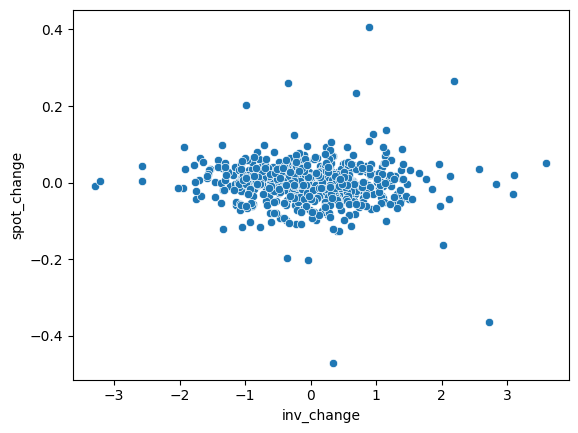

In [223]:
sns.scatterplot(priced_in, x='inv_change', y='spot_change')

In [227]:
priced_in.corr()

,inv_change,spot_change
inv_change,1.000000,-0.109402
spot_change,-0.109402,1.000000
